<a href="https://colab.research.google.com/github/DEli-26/DS_Practicum/blob/main/02_reliability/deli_proj_pract_02_reliability_v2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size=6><b>**Я.Практикум. Проект №2**</b></font>

<font size=6><b>**Надежность заемщиков**</b></font>

---

# Постановка задачи

**Заказчик:** кредитный отдел банка. 

**Цель:** провести исследования для построения модели кредитного скоринга — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

**Задачи:** 
1. определить наличие зависимости между семейным положением и фактом погашения кредита в срок;
2. определить наличие зависимости между количеством детей и фактом погашения кредита в срок.

**Исходные данные:** статистика о платёжеспособности клиентов.

# Обзор данных

Загрузим библиотеки, необходимые для выполнения проекта

In [ ]:
import pandas as pd
import seaborn as sns

Исходные данные находятся в файле `data.csv`. Откроем его и выведем первые 5 строк.

-- Здесь был код с загрузкой данных --

Получим общую информацию по изучаемому датасету.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


Согласно документации, описание столбцов следующее:

- `children` — количество детей в семье;
- `days_employed` — общий трудовой стаж в днях;
- `dob_years` — возраст клиента в годах;
- `education` — уровень образования клиента;
- `education_id` — идентификатор уровня образования;
- `family_status` — семейное положение;
- `family_status_id` — идентификатор семейного положения;
- `gender` — пол клиента;
- `income_type` — тип занятости;
- `debt` — имел ли задолженность по возврату кредитов;
- `total_income` — ежемесячный доход;
- `purpose` — цель получения кредита.

Итого в датасете 12 столбцов и 21525 строк. Тип данных вещественный `float64` и текстовый `object`.

В датасете проведена категоризация данных по образованию и семейному положению клиентов, что целесообразно использовать при проведении исследования.

Размер датасета равен около 2 Мб, что не вызовет вычислительных сложностей с обработкой данных, следовательно, изменение поддтипов данных не требуется.

Нарушений стиля в наименовании столбцов нет, их корректировка не требуются. 

В столбцах `days_employed` и `total_income` содержатся пропуски, а тип данных столбцов `total_income` и `days_employed` не соответствует описанию и для удобства обработки может быть изменен с `float64` на `int64`.

In [ ]:
cnt_nan_dys_empl = df['days_employed'].isna().sum()
cnt_nan_ttl_incm = df['total_income'].isna().sum() 
print("Пропусков в столбце 'days_employed':", cnt_nan_dys_empl)
print("Пропусков в столбце 'total_income':", df['total_income'].isna().sum())

Пропусков в столбце 'days_employed': 2174
Пропусков в столбце 'total_income': 2174


Учитывая, что в исходных данных не приведена расшифровка значений в столбце `debt`, определим процентное соотношение значений в нем.

In [ ]:
df['debt'].value_counts(normalize=True)

0    0.919117
1    0.080883
Name: debt, dtype: float64

Так как значений `1` не более 8% от общего количества строк, делаем вывод, что оно означает **наличие** факта задолженности по кредиту.

**Выводы**

В каждой строке таблицы — данные о пользователях банка. Часть колонок описывает сведения о личной жизни пользователя: количество детей, возраст, семейное положение, пол. Остальные данные рассказывают о его карьере и финансовом положении: трудовой стаж, образование, тип занятости,  наличие задолженности по возврату кредитов, доход и цель получения кредита. 

Предварительно можно утверждать, что, данных достаточно для проверки гипотез. Однако встречаются неправильный тип и пропуски в данных, а также возможно проявление дупликатов и других аномалий. Чтобы двигаться дальше, нужно устранить перечисленные проблемы в данных.

# Предобработка данных

Проведем предобработку в следующей последовательности:

1. аномалии;
2. пропуски;
3. неявные дупликаты;
3. явные дупликаты.

## Аномалии

В датасете содержаться **четыре** аномалии. 

**Первая** аномалия - это значения в столбце `days_employed`. Ее хорошо видно на диаграмме рассеивания

Количество клиентов с отрицательным стажем: 15906 (73.9%)
Количество клиентов с положительным стажем: 3445 (16.0%)


<AxesSubplot:xlabel='days_employed', ylabel='dob_years'>

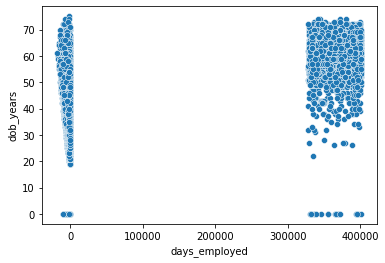

In [ ]:
dys_empl_minus = df.loc[df['days_employed'] <= 0, 'days_employed']
dys_empl_plus = df.loc[df['days_employed'] > 0, 'days_employed']
print('Количество клиентов с отрицательным стажем:', dys_empl_minus.count(), f'({dys_empl_minus.count()/len(df):.1%})')
print('Количество клиентов с положительным стажем:', dys_empl_plus.count(), f'({dys_empl_plus.count()/len(df):.1%})')

sns.scatterplot(x=df['days_employed'], y=df['dob_years'])

На представленной диаграмме хорошо видно два типа аномальных значений:

- отрицательные значения,
- большой разрыв в стаже работы клиентов от 0 до примерно 320 000 дней. 

Первый тип может быть вызван особенностью ввода данных в датасет, согласно которому стаж клиента вычисляется вычитанием из даты начала трудового стажа даты предоставления данных (подачи заявки на кредит).

Учитывая, что 320 000 дней соответствует примерно 900 годам, второй тип аномальных значений может свидетельствовать о более серьезном повреждении данных. Для исследования причин последнего, проанализируем, каким категориям по типу дохода (столбец `income_type`) соответствует отрицательный стаж, а каким - положительный. Наиболее наглядный способ такого анализа - построение диаграммы рассеивания.

<AxesSubplot:xlabel='days_employed', ylabel='income_type'>

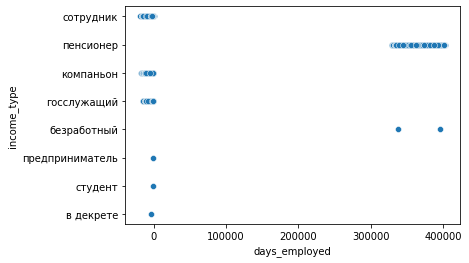

In [ ]:
sns.scatterplot(x=df['days_employed'], y=df['income_type'])

Из представленной диаграммы следует, что все клиенты с положительным стажем работы относятся к категории клиентов пенсионеры или безработные, а с отрицательным - к остальным категориям. Согласно полученным результатам можно предположить, что для указанных категорий клиентов может предномеренно завышаться значение стажа работы до нереалистичных значений (320 000 дней соответсвует примерно 900 годам) ввиду их повышенной надежности за счет обеспеченности государственными выплатами. 

Стоит отметить, что достоверно предположить причину проявления полученных аномалий невозможно, так как для этого следует обратиться к источнику данных за консультацией. 

Полученные аномалии можно рассматривать, как частный случай пропусков данных. Учитывая, что доход клиентов в большинстве случаев коррелирует с их стажем работы, который, в свою очередь, имеет связь с возрастом, подобные пропуски являются неслучайным явлением (MNAR), следовательно, их исключение существенно повлияет на репрезентативность выборки. Замена аномальных значений стажа средним или медианным значениями всего столбца со стажем изменит статистические свойства датасета и повлияет на точность проводимых исследований. В этой связи, учитывая описанную выше корреляцию, замену пропущенных значений в столбцах `days_employed` проведем на основе имеющихся данных в столбце `dob_years`.  

Количество отрицательных стажей примерно в 4,5 раза больше положительных, следовательно, будем считать отрицательные значения стажа реалистичнее положительных. Для обработки данных создадим функцию `repair_exp`, которая:
- для каждого клиента с отрицательным стажем возвращает его инвертированное целочисленное значение;
- для каждого клиента с положительным стажем возвращает инвертированное медианное целочисленное значение стажа работы для группы клиентов, у которых стаж отрицательный, а возраст лежит в диапазоне [-2, +2] от возраста клиента.

Применение целочисленных значений оправдано тем, что учет стажа ведется с точностью до одного дня.
Применение медианного значения вместо среднего оправдано тем, что оно менее подвержено выбросам на концах диапазона.
Возрастной диапазон выбран исходя из предположения, что в рамках группы людей с различием возраста 5 лет, стаж может быть усреднен.

In [ ]:
def repair_exp(row):
    age = row['dob_years']
    exp = row['days_employed']
    range = 2
    if exp < 0:
        return int(-1*exp)
    return int(df.loc[(df['dob_years']>=(age-range))&(df['dob_years']<=(age+range))&(df['days_employed']<0), 'days_employed'].median()*-1)

Применим к исследуемому датасету созданную функцию.

<AxesSubplot:xlabel='days_employed_rep', ylabel='dob_years'>

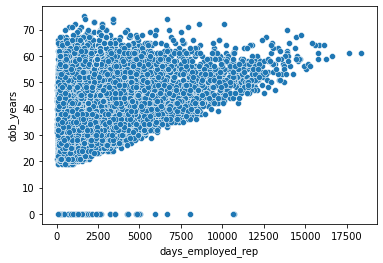

In [ ]:
df['days_employed_rep'] = df.apply(repair_exp, axis=1)
sns.scatterplot(x=df['days_employed_rep'], y=df['dob_years'])

Приведенная диаграмма свидетельствует о том, что функция сработала корректно.

**Вторая** аномалия в датасете - это нулевые значения в графе `dob_years`, что видно на диаграмме рассеивания, приведенной выше. Учитывая, что возраст клиентов, как правило, является обязательным при составлении кредитной заявки, его нулевые значения можно считать техническим сбоем, произошедшем в ходе подготовки данных. 

Как уже отмечалось, возраст коррелирует со стажем работы, в связи с чем нулевые значения первого целесообразно обработать с учетом второго. Для этого определим функцию `repair_age`, которая для каждого клиента с нулевым значением возраста возвращает медианное значение возраста для группы клиентов, стаж которых лежит в диапазоне [-150, +150] от стажа клиента.

Диапазон стажа выбран исходя из предположения, что в рамках группы людей с различием стажа 1 год, возраст может быть усреднен.

In [ ]:
def repair_age(row):
    age = row['dob_years']
    exp = row['days_employed_rep']
    range = 150
    if age == 0:
        return int(df.loc[(df['days_employed_rep']>=(age-range))&(df['days_employed_rep']<=(age+range)), 'dob_years'].median())
    return int(age)

<AxesSubplot:xlabel='days_employed_rep', ylabel='dob_years_rep'>

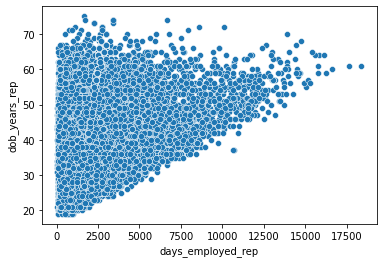

In [ ]:
df['dob_years_rep'] = df.apply(repair_age, axis=1)
sns.scatterplot(x=df['days_employed_rep'], y=df['dob_years_rep'])

**Третья** аномалия - это неожиданное значение `XNA` в столбце `gender`:

In [ ]:
df['gender'].value_counts()

F      14236
M       7288
XNA        1
Name: gender, dtype: int64

Учитывая, что такое значение встречается единожды - его можно считать абсолютно случайным событием (MCAR), а следовательно,  его замена не приведет к снижению точности исследования.

In [ ]:
df.loc[df['gender'] == 'XNA', 'gender'] = 'M'
df['gender'].value_counts()

F    14236
M     7289
Name: gender, dtype: int64

**Четвертая** аномалия содержится в столбце `children` в виде значений `-1` и `20`:

In [ ]:
df['children'].value_counts()

 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

Учитывая, что количество ложных значений менее 0,6% от общего числа данных в выборке, их появление можно считать абсолютно случайным событием (MCAR). Следовательно, аналогично аномалии в столбце `gender`, их замена не приведет к снижению точности исследования. Обработаем значения в столбце `children` следующим образом:

In [ ]:
df.loc[df['children'] == -1, 'children'] = 1
df.loc[df['children'] == 20, 'children'] = 2
df['children'].value_counts()

0    14149
1     4865
2     2131
3      330
4       41
5        9
Name: children, dtype: int64

## Пропуски

Согласно, общей информации, в столбцах `days_employed` и `total_income` присутсвуют в одинаковом количестве пропущенные данные.

Количество пропусков в каждом столбце в процентном соотношении составляет:

In [ ]:
round(df['total_income'].isna().sum() / df['total_income'].isna().count() * 100, 1)

10.1

Полученное значение может оказать существенное влияние на результаты исследования, кроме того, в случае, если пропуски содержаться в разных строках, количество пропусков во всем датасете может быть увеличено до 20%. В этой связи  необходимо проверить гипотезу: *пропуски содержаться в одних и тех же строках*, для чего выполним код: 

In [ ]:
df_nan = pd.DataFrame(data=df['days_employed'], columns=['days_employed'])
df_nan['total_income'] = df['total_income']
df_nan['days_employed'] = df_nan['days_employed'].fillna('NONE')
df_nan['total_income'] = df_nan['total_income'].fillna('NONE')

cnt_nan = 0
for i in range(len(df_nan)):
    if df_nan.loc[i, 'days_employed'] == 'NONE' and df_nan.loc[i, 'total_income'] == 'NONE':
        cnt_nan += 1
cnt_nan

2174

Значение переменной `cnt_nan` совпадает со значением пропусков в каждом столбце что подтверждает гипотезу. Таким образом, количество строк с пропусками не превышает 10% от общего количества. 

Обработку пропусков в столбце `days_employed` проведем аналогично обработке отрицательных и больших значений в нем, описанной выше. Для этого заменим все пропуски нулевым значением и перезапишем столбец `days_employed_rep`, применив функцию `repair_exp`.

<AxesSubplot:xlabel='days_employed_rep', ylabel='dob_years_rep'>

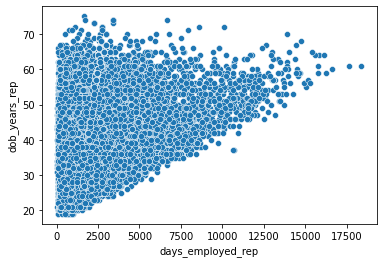

In [ ]:
df['days_employed'] = df['days_employed'].fillna(0)
df['days_employed_rep'] = df.apply(repair_exp, axis=1)
sns.scatterplot(x=df['days_employed_rep'], y=df['dob_years_rep'])

Обработку пропусков в столбце `total_income` проведем с учетом того, что они являются неслучайным явлением (MNAR), следовательно, их исключение повлияет на репрезентативность выборки. Для этого определим функцию `repair_inc`, которая для каждого клиента с нулевым значением дохода возвращает его целочисленное медианное значение для группы клиентов с тем же типом занятости.

Обоснование использование медианных значений аналогично приведенному выше.
Применение целочисленных значений оправдано упрощением восприятия обрабатываемой информации о доходе клиентов.

In [ ]:
def repair_inc(row):
    inc = row['total_income']
    job = row['income_type']
    if inc == 0:
        return int(df.loc[df['income_type']==job, 'total_income'].median())
    return int(inc)

Заменим все пропуски нулевым значением и применим функцию `repair_inc` к датасету.

<AxesSubplot:xlabel='days_employed_rep', ylabel='total_income_rep'>

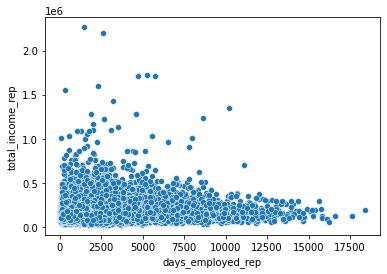

In [ ]:
df['total_income'] = df['total_income'].fillna(0)
df['total_income_rep'] = df.apply(repair_inc, axis=1)
sns.scatterplot(x=df['days_employed_rep'], y=df['total_income_rep'])

## Неявные дупликаты

Неявные дупликаты содержаться в столбцах с категориальными значениями: `education`, `purpose`:

In [ ]:
df['education'].value_counts()

среднее                13750
высшее                  4718
СРЕДНЕЕ                  772
Среднее                  711
неоконченное высшее      668
ВЫСШЕЕ                   274
Высшее                   268
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
УЧЕНАЯ СТЕПЕНЬ             1
Ученая степень             1
Name: education, dtype: int64

In [ ]:
df['purpose'].value_counts()

свадьба                                   797
на проведение свадьбы                     777
сыграть свадьбу                           774
операции с недвижимостью                  676
покупка коммерческой недвижимости         664
операции с жильем                         653
покупка жилья для сдачи                   653
операции с коммерческой недвижимостью     651
покупка жилья                             647
жилье                                     647
покупка жилья для семьи                   641
строительство собственной недвижимости    635
недвижимость                              634
операции со своей недвижимостью           630
строительство жилой недвижимости          626
покупка недвижимости                      624
покупка своего жилья                      620
строительство недвижимости                620
ремонт жилью                              612
покупка жилой недвижимости                607
на покупку своего автомобиля              505
заняться высшим образованием      

Все неявные дупликаты в столбце `education` вызваны различным регистром вводимой информации, следовательно, их исключение обеспечивается при помощи метода `str.lower()`:

In [ ]:
df['education'] = df['education'].str.lower()
df['education'].value_counts()

среднее                15233
высшее                  5260
неоконченное высшее      744
начальное                282
ученая степень             6
Name: education, dtype: int64

Неявные дупликаты в столбце `purpose` могут быть исключены при помощи метода `replace()` и словаря дупликатов. Однако для этого следует получить консультацию у источника данных, на сколько важно различие близких по смыслу значений. Например, 'операции с коммерческой недвижимостью' и 'операции со своей недвижимостью'.

Вместо указанного подхода в решаемой задаче целесообразно использовать категоризацию по значениям. Для этого создадим функцию `purpose_cat`, которая на основании данных из столбца `purpose` сформирует новый столбец `purpose_category`, в который войдут следующие категории:
* ‘операции с автомобилем’,
* ‘операции с недвижимостью’,
* ‘проведение свадьбы’,
* ‘получение образования’.

In [ ]:
def purpose_cat(row):
    if 'автомоби' in row['purpose']:
        return 'операции с автомобилем'
    elif 'недвиж' in row['purpose'] or 'жил' in row['purpose']:
        return 'операции с недвижимостью'
    elif 'свадьб' in row['purpose']:
        return 'проведение свадьбы'
    elif 'образов' in row['purpose']:
        return 'получение образования'

In [ ]:
df['purpose_category'] = df.apply(purpose_cat, axis=1)
df['purpose_category'].value_counts()

операции с недвижимостью    10840
операции с автомобилем       4315
получение образования        4022
проведение свадьбы           2348
Name: purpose_category, dtype: int64

## Явные дупликаты

После обработки аномалий, пропусков и неявных дупликатов в исследуемом датасете можно преступить к обработке явных. Начнем с определения их количества.

In [ ]:
df.duplicated().sum()

71

Обработку явных дупликатов проведем при помощи метода `drop_duplicates()` после чего проверим их количество:

In [ ]:
df = df.drop_duplicates().reset_index(drop=True)
df.duplicated().sum()

0

Явных дупликатов не осталось.

## Группировка данных

После решения обнаруженных проблем с датасетом сгруппируем данные для удобства их анализа. Для этого создадим два новых датафрейма со значениями из столбцов:
* `education_id` и `education` — в первом;
* `family_status_id` и `family_status` — во втором.

In [ ]:
df_edu = df.groupby('education_id')['education'].max()
df_edu

education_id
0                 высшее
1                среднее
2    неоконченное высшее
3              начальное
4         ученая степень
Name: education, dtype: object

In [ ]:
df_fam = df.groupby('family_status_id')['family_status'].max()
df_fam

family_status_id
0          женат / замужем
1         гражданский брак
2           вдовец / вдова
3                в разводе
4    Не женат / не замужем
Name: family_status, dtype: object

Удалим из исходного датасета столбцы `education` и `family_status`, оставив только их идентификаторы: `education_id` и `family_status_id`.

In [ ]:
df = df.drop(['education','family_status'], axis=1)
df.head(5)

,children,days_employed,dob_years,education_id,family_status_id,gender,income_type,debt,total_income,purpose,days_employed_rep,dob_years_rep,total_income_rep,purpose_category
0,1,-8437.673028,42,0,0,F,сотрудник,0,253875.639453,покупка жилья,8437,42,253875,операции с недвижимостью
1,1,-4024.803754,36,1,0,F,сотрудник,0,112080.014102,приобретение автомобиля,4024,36,112080,операции с автомобилем
2,0,-5623.422610,33,1,0,M,сотрудник,0,145885.952297,покупка жилья,5623,33,145885,операции с недвижимостью
3,3,-4124.747207,32,1,0,M,сотрудник,0,267628.550329,дополнительное образование,4124,32,267628,получение образования
4,0,340266.072047,53,1,1,F,пенсионер,0,158616.077870,сыграть свадьбу,2265,53,158616,проведение свадьбы


Cоздадим столбец `total_income_category` с категориями по значениям в столбце `total_income_rep`:
* 0 – 30 000 — 'E';
* 30 001 – 50 000 — 'D';
* 50 001 – 200 000 — 'C';
* 200 001 – 1 000 000 — 'B';
* 1 000 001 и выше — 'A'.

In [ ]:
df['total_income_category'] = pd.cut(df['total_income_rep'], [0, 30000, 50000, 200000, 1000000, float('inf')], 
                                     labels=['E','D','C','B','A'])

## Выводы

В результате предобработки данных выявлены и решены следующие проблемы с датасетом:

1. Аномалии в виде отрицательных, нулевых и неожиданных значений в столбцах `days_employed`, `dob_years`, `gender` и `children` соответственно. 
1. Пропущенные данные в столбцах `days_employed` и `total_income`.
1. Неявные дупликаты в столбцах `education` и `purpose`.
1. Явные дупликаты.

Кроме того, созданы группы клиентов по уровню дохода от 'A' до 'E'.

Теперь можно перейти к проверке гипотез.

# Проверка гипотез

Согласно поставленным задачам, необходимо проверить две гипотезы. 

## Семейное положение влияет на факт погашения кредита в срок

Для нахождения зависимость между семейным положением и возвратом кредита в срок проведем группировку датасета по столбцу `family_status_id` и посчитаем сумму, общее количество и их отношение. Последнее будет наиболее показательным для принятия решения о наличии зависимости.

In [ ]:
impct_fam = df.groupby('family_status_id')['debt'].agg({'count', 'sum'})
impct_fam['%'] = impct_fam['sum']/impct_fam['count']
impct_fam = impct_fam.merge(df_fam, on='family_status_id')
impct_fam.sort_values(by='%')

,sum,count,%,family_status
family_status_id,,,,
2,63,959,0.065693,вдовец / вдова
3,85,1195,0.071130,в разводе
0,931,12339,0.075452,женат / замужем
1,388,4151,0.093471,гражданский брак
4,274,2810,0.097509,Не женат / не замужем


По полученным значениям видно, что **зависимость между семейным положением и возвратом кредита в срок** проявляется в следующем:
* больше всего невозвратов у клиентов, не состоящих в браке - 9,7%;
* вдовцы/вдовы на 3% более надежные клиенты с точки зрения возврата кредитов.

## Количество детей влияет на факт погашения кредита в срок.

Аналогично проверке первой гипотезы, проведем группировку данных.

In [ ]:
impct_kids = df.groupby('children')['debt'].agg({'count', 'sum'})
impct_kids['%'] = impct_kids['sum']/impct_kids['count']
impct_kids.sort_values(by='%')

,sum,count,%
children,,,
5,0,9,0.000000
0,1063,14091,0.075438
3,27,330,0.081818
1,445,4855,0.091658
2,202,2128,0.094925
4,4,41,0.097561


По полученным значениям видно, что вывод о клиентах с пятью детьми делать не целесообразно ввиду малого количества данных по ним. При этом, **зависимость между количеством детей и возвратом кредита в срок** проявляется в следующем виде:
* больше всего невозвратов у клиентов c четырьмя, двумя или одним ребенком. Различие для этих групп не превосходит 0,6%, может быть обусловлено разным размером выборки для каждой и составляет около 9,5%;
* клиенты без детей наиболее надежные с точки зрения возврата кредитов.

## Проверка дополнительных гипотез

Проведем дополнительно изучение двух гипотез 

### Уровень дохода влияет на факт погашения кредита в срок

Аналогично предыдущим проверкам гипотез, проведем группировку данных.

In [ ]:
impct_inc = df.groupby('total_income_category')['debt'].agg({'count', 'sum'})
impct_inc['%'] = impct_inc['sum']/impct_inc['count']
impct_inc.sort_values(by='%')

,sum,count,%
total_income_category,,,
D,21,350,0.060000
B,356,5042,0.070607
A,2,25,0.080000
C,1360,16015,0.084920
E,2,22,0.090909


По полученным значениям видно, что определять зависимость между уровнем дохода и возвратом кредита в срок для клиентов с доходом категорий `A (от 1 000 001)` и `E (0 – 30 000)` может быть преждевременным ввиду малой выборки данных. **Зависимость между уровнем дохода и возвратом кредита в срок** для остальных категорий клиентов проявляется в следующем виде:
* больше всего невозвратов у клиентов с доходом категории `C (50 001 – 200 000)` - 8,5%;
* клиенты с доходом категории `D (30 001 – 50 000)` наиболее надежные с точки зрения возврата кредитов.

### Цели кредита влияют на факт его погашения в срок

Аналогично предыдущим проверкам гипотез, проведем группировку данных.

In [ ]:
impct_aim = df.groupby('purpose_category')['debt'].agg({'count', 'sum'})
impct_aim['%'] = impct_aim['sum']/impct_aim['count']
impct_aim.sort_values(by='%')

,sum,count,%
purpose_category,,,
операции с недвижимостью,782,10811,0.072334
проведение свадьбы,186,2324,0.080034
получение образования,370,4013,0.092200
операции с автомобилем,403,4306,0.093590


По полученным значениям видно, что **зависимость между целью кредита и возвратом его в срок** проявляется в следующем виде:
* больше всего рисков по невозврату кредитов, взятых на операции с автомобилем или получение образования. Различие для этих групп не превосходит 0,1%, может быть обусловлено статистическим разбросом и составляет около 9,2%
* наименьший риск по невозврату для кредитов, взятых на операции с недвижимостью.

# Выводы

Проведено исследование статистики о платёжеспособности клиентов.

В результате предобработки данных выявлены и решены такие проблемы с датасетом, как аномалии данных, пропуски в них, явные и неявные дупликаты, а также созданы группы клиентов по уровню дохода от 'A' (от 1 000 001) до 'E' (0 – 30 000).

Проверка основных гипотез показала следующее.

1. Наибольший риск по невозврату кредитов у клиентов, не состоящих в браке. Указанные клиенты в 9,7% случаев имеют задолженности. При этом вдовцы/вдовы являются наиболее надежными и имеют задолжности в 6,5% случаев.
2. Разница количества задолженностей по кредиту клиентов c четырьмя, двумя или одним ребенком не превосходит 0,6% и изменяется в диапазоне от 9,2% до 9,8%. Полученные значения могут быть обусловлены разным размером выборки для каждой группы клиентов. При этом, клиенты без детей являются наиболее надежными и имеют задолженности в 7,5% случаев.

Дополонительно проверены гипотезы влияния на факт погашения кредита в срок уровня дохода и цели кредита. Результаты проверки показали следующее.

1. Зависимость между уровнем дохода и возвратом кредита в срок для клиентов с доходом категорий 'A' и 'E' невозможно определить ввиду малой выборки данных. При этом больше всего невозвратов у клиентов с доходом категории 'C' и составляет 8,5%, а у клиентов с доходом категории 'D' - меньше всего и составляет 6%. 
1. Больше всего рисков по невозврату кредитов, взятых на операции с автомобилем или получение образования. Различие для этих групп не превосходит 0,13%, может быть обусловлено статистическим разбросом и составляет около 9,4%. Наименьший риск по невозврату приходится для кредитов, взятых на операции с недвижимостью, и составляет 7,2%.

Таким образом, на возврат кредита в срок влияют все рассмотренные факторы. Тем не менее, для критерия семейного положения получено максимальное значение диапазона значений - 3,2%, что делает его наиболее критичным для построения модели кредитного скоринга. 
последний критерий влияет в меньшей степени, что видно благодаря меньшему разбросу значений - 2,3% против 3,2% для критерия семейного положения. 